In [2]:
# My code
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
from ephys import rasters
import pyslsa

# System Libs
from importlib import reload
import pickle
import glob
import os

# Scientific Libs
import numpy as np
from scipy.optimize import brentq
import tqdm

# Plotting libs
import matplotlib.pyplot as plt

# Set some parameters
%matplotlib inline
reload(sa)
reload(sc)
reload(pyslsa)
import time
np.random.seed(int(time.time()))


/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [104]:
def binmat_to_scg_C(sptrain):
    msimps = sc.binarytomaxsimplex(sptrain, True)
    return pyslsa.build_SCG(msimps)
def loss_C(a, beta, Etarget, dim, ncells, nwin, nsamples2):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    #Emodels = precompute_test_scg(binMatsamples)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(nsamples2):
        maxsimps = sc.binarytomaxsimplex(binMatsamples[:, :, ind], rDup=True)
        # Compute SCG for test spike trains
        #Emodel = Emodels[ind]
        Emodel = pyslsa.build_SCG(maxsimps)

        # Compute KL divergence for this test spike train and store it. 
        #%time div = pyslsa.KL(Etarget, Emodel, dim, beta)
        div = pyslsa.KL(Etarget, Emodel, dim, beta)
        KLsave.append(div)
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def run_simulation(alphas):
    KLS = []
    for alpha in alphas:
        # Generate binary matrix with given probabilities for each "cell"
        ncells = 20
        nwin = 1000
        nsamples2 = 25
        dim=1
        a = alpha
        print(a)
        probs = (a*np.ones((ncells, 1)))
        nsamples = 2
        samples = np.random.rand(ncells, nwin, nsamples)
        probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
        probmat = np.tile(probmat, (1, 1, nsamples))
        binMatsamples = np.greater(probmat, samples).astype(int)
        # Compute SCG for each sample
        SCGs = []
        for ind in range(nsamples):
            E = binmat_to_scg_C(binMatsamples[:, :, ind])
            SCGs.append(E)
        Etarget = SCGs[0]
        Etest = SCGs[1]

        SCGs_old = []
        for ind in range(nsamples):
            msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
            E = sc.simplicialChainGroups(msimps)
            SCGs_old.append(E)
        Etarget_old = SCGs_old[0]
        Etest_old = SCGs_old[1]
        
        est_save = []
        ntrials = 1
        X = np.linspace(0.001, 0.1, 50)
        beta = 0.2
        #print(t)
        KL=[]
        JS = []
        KLerr = []
        JSerr = []
        for i, x in tqdm.tqdm(enumerate(X)):
            #print(x)
            (m, stderr) = loss_C(x, beta, Etarget, dim, ncells, nwin, nsamples2)
            KL.append(m)
            KLerr.append(stderr)
        KLS.append((KL, KLerr))
        
    return KLS, X

In [105]:
alphas = [0.01, 0.02, 0.03, 0.04]
kls, X = run_simulation(alphas)

3it [00:00, 20.82it/s]

0.01


50it [00:31,  1.58it/s]
3it [00:00, 19.63it/s]

0.02


50it [00:32,  1.56it/s]
2it [00:00, 12.71it/s]

0.03


50it [00:33,  1.50it/s]
1it [00:00,  7.85it/s]

0.04


50it [00:37,  1.34it/s]


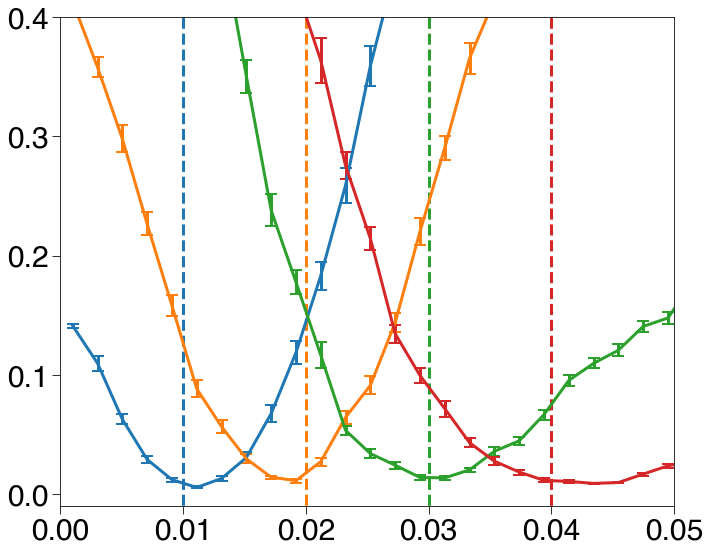

In [106]:

#sns.set_style('white')
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111)
for ind, (KL, KLerr) in enumerate(kls):

    p, _, _ = ax.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2)
    ax.plot([alphas[ind], alphas[ind]], [-2, 2], color=p.get_color(), linestyle='--', linewidth=3)
    
ax.tick_params(which='both', labelsize=30, length=8)
for tick in ax.get_xticklabels():
    tick.set_fontname('helvetica')
for tick in ax.get_yticklabels():
    tick.set_fontname('helvetica')
    
ax.set_ylim(-0.01, 0.4)
ax.set_xlim(0.0, 0.05)
figpath = os.path.join(figsavepth, 'PoissonModelFit1Group.eps')
plt.savefig(figpath)

In [14]:
import os
import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)
figpath = os.path.join(figsavepth, 'PoissonModelFit1Group.eps')
plt.savefig(figpath)


/home/brad/DailyLog/20180206/


In [30]:
def loss_C_2group(a, b, beta, Etarget, dim, ncells, nwin, nsamples2):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))

    # Generate new spike trains
    samples = np.random.rand(2*ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    #Emodels = precompute_test_scg(binMatsamples)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(nsamples2):
        maxsimps = sc.binarytomaxsimplex(binMatsamples[:, :, ind], rDup=True)
        # Compute SCG for test spike trains
        #Emodel = Emodels[ind]
        Emodel = pyslsa.build_SCG(maxsimps)

        # Compute KL divergence for this test spike train and store it. 
        #%time div = pyslsa.KL(Etarget, Emodel, dim, beta)
        div = pyslsa.KL(Etarget, Emodel, dim, beta)
        KLsave.append(div)
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def run_simulation_2group(alphas):
    KLS = []
    for alphap in alphas:
        a = alphap[0]
        b = alphap[1]
        # Generate binary matrix with given probabilities for each "cell"
        ncells = 10
        nwin = 1000
        nsamples2 = 5
        dim=1
        nsamples = 2
        probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
        samples = np.random.rand(2*ncells, nwin, nsamples2)
        probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
        probmat = np.tile(probmat, (1, 1, nsamples2))
        binMatsamples = np.greater(probmat, samples).astype(int)
        # Compute SCG for each sample
        SCGs = []
        for ind in range(nsamples):
            E = binmat_to_scg_C(binMatsamples[:, :, ind])
            SCGs.append(E)
        Etarget = SCGs[0]
        Etest = SCGs[1]

        SCGs_old = []
        for ind in range(nsamples):
            msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
            E = sc.simplicialChainGroups(msimps)
            SCGs_old.append(E)
        Etarget_old = SCGs_old[0]
        Etest_old = SCGs_old[1]
        
        est_save = []
        ntrials = 1
        X = np.linspace(0.001, 0.1, 50)
        Y = np.linspace(0.001, 0.1, 50)
        Xs, Ys = np.meshgrid(X, Y)
        beta = 0.2
        #print(t)
        KL=[]
        JS = []
        KLerr = []
        JSerr = []
        for x in tqdm.tqdm(X):
            #print(x)
            for y in Y:
                #print(y)
                (m, stderr) = loss_C_2group(x, y, beta, Etarget, dim, ncells, nwin, nsamples2)
                KL.append(m)
                KLerr.append(stderr)
        KLS.append((KL, KLerr))
        
    return KLS, X


In [76]:
alphas = [(0.02, 0.05)]
kls, x = run_simulation_2group(alphas)

100%|██████████| 50/50 [04:21<00:00,  5.23s/it]


In [9]:
import pickle
with open('/home/brad/2grouptest20180206.pkl', 'wb') as f:
    pickle.dump((kls, x), f)

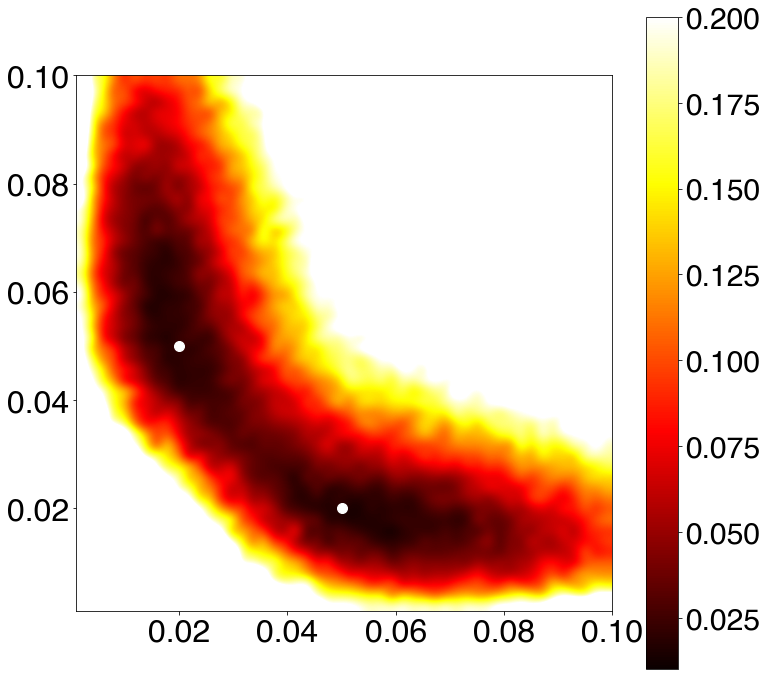

In [103]:
KL = [x[0] for x in kls]
KL = np.reshape(KL, (50, 50))
plt.figure(figsize=(12, 12))
plt.imshow(KL, interpolation='bicubic', origin='lower',
                cmap='hot', extent=(0.001, 0.1, 0.001, 0.1),vmin=0.01, vmax=0.2)
plt.plot([alphas[0][0]], [alphas[0][1]], 'wo', markersize=10)
plt.plot([alphas[0][1]], [alphas[0][0]], 'wo', markersize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30, )
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family('helvetica')
levels = np.linspace(0.001, 0.07, 12)
#CS = plt.contour(KL, origin='lower', levels=levels, linewidths=2,extent=(0.001, 0.1, 0.001, 0.1), cmap='jet')
ax = plt.gca()
#ax.set_xticks(np.arange(0.01, 0.1, 0.02))
for i in ax.get_xticklabels():
    i.set_fontsize(32)
    i.set_fontname('helvetica')
for i in ax.get_yticklabels():
    i.set_fontsize(32)
    i.set_fontname('helvetica')

figpath = os.path.join(figsavepth, 'PoissonModelFit2GroupAlt2.eps')
plt.savefig(figpath)

In [98]:
import os
import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)
figpath = os.path.join(figsavepth, 'PoissonModelFit2GroupAlt2_LogScale.eps')
plt.savefig(figpath)

/home/brad/DailyLog/20180207/


In [36]:
np.amin(KL)

0.007982494935981735

In [26]:
np.arange(0.01, 1.4, 50)

array([0.01])